In [1]:
import gstools as gs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import xarray as xr
import cartopy.crs as ccrs
from cartopy import geodesic as cgeod
from geopy.distance import geodesic 
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize

import matplotlib.cm as cm
from multiprocess import Pool

import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
import os
import scipy.stats as stats


In [2]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [3]:
def calculate_rmse(array1, array2):
    """
    Compute the Root Mean Square Error (RMSE) between two arrays.

    Parameters:
    - array1: First set of values (e.g., station rain rates)
    - array2: Second set of values (e.g., radar rain rates)

    Returns:
    - RMSE value
    """
    array1 = np.array(array1)
    array2 = np.array(array2)

    if array1.shape != array2.shape:
        raise ValueError("Both arrays must have the same shape.")

    return np.sqrt(np.nanmean((array1 - array2) ** 2))

In [4]:
def get_tercile_val(scale_arr):
    th1 = np.percentile(scale_arr[scale_arr>0], 33.3)
    th2 = np.percentile(scale_arr[scale_arr>0], 66.6)
    return th1, th2

# Function to categorize into terciles
def assign_tercile(values, thresholds):
    return np.digitize(values, thresholds, right=True)  # Returns 0, 1, or 2

# Get stations

In [18]:
df = pd.read_csv("/g/data/k10/dl6968/CLEX_analysis/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{stn_id}_pair_scale_moving_list_all_events.csv'):
        exclude_stn.append(stn_id)
# ## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]


In [6]:

## test these stations for Brisbane first
## daily center
## consider number of years
center_stations = []
center_radius = 100
center_lat, center_lon =   -27.5436, 152.3375# -12.4239,  130.8925#-31.9275,  117.9764 #-12.4239,  130.8925
for i in range(0,len(df)):
    station  = (df["Latitude"].iloc[i],  df["Longitude"].iloc[i])
    distance = geodesic((center_lat,center_lon), station).kilometers

    if distance <= center_radius and df["Years"].iloc[i]>=20:
            center_stations.append(df["ID"].iloc[i])

df_center = df[(df["ID"].isin(center_stations)) & (df["End_Year"]>=1960)]   

In [7]:
avail_stn = []
for stn_id in df_center["ID"]:
    if os.path.exists(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1980/{stn_id}_pair_scale_moving_list_all_events.csv"):
        avail_stn.append(stn_id)

In [41]:
df_1980_stn = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1980/{stn_id}_station_moving_list_all_events.csv",index_col=0)

In [ ]:
scale_1980 = []
scale_all = []
dates_list = []
station_count_diff = []

for stn_id in tqdm(avail_stn, position=0, leave=True):
    df_1980 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1980/{stn_id}_pair_scale_moving_list_all_events.csv",index_col=0)
    df_all = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{stn_id}_pair_scale_moving_list_all_events.csv",index_col=0)
    df_1980_stn = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1980/{stn_id}_station_moving_list_all_events.csv",index_col=0)
    df_all_stn = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{stn_id}_station_moving_list_all_events.csv",index_col=0)
    for dates in df_1980["extreme_dates"]:
        if dates in np.unique(df_all["extreme_dates"]):
            if df_1980["scale"][df_1980["extreme_dates"]==dates].values[0]>1 and df_all["scale"][df_all["extreme_dates"]==dates].values[0]>1:
                stn_count_1980 = len(df_1980_stn[(df_1980_stn["Date"]==dates) & (df_1980_stn["val"]>0)])
                stn_count_all = len(df_all_stn[(df_all_stn["Date"]==dates) & (df_all_stn["val"]>0)])
                station_count_diff.append(stn_count_all-stn_count_1980)
                scale_1980.append(df_1980["scale"][df_1980["extreme_dates"]==dates].values[0])
                scale_all.append(df_all["scale"][df_all["extreme_dates"]==dates].values[0])
                dates_list.append(dates)
    
scale_1980 = np.array(scale_1980)
scale_all = np.array(scale_all)

 71%|███████▏  | 77/108 [15:52<07:58, 15.45s/it]

Text(0, 0.5, 'Count')

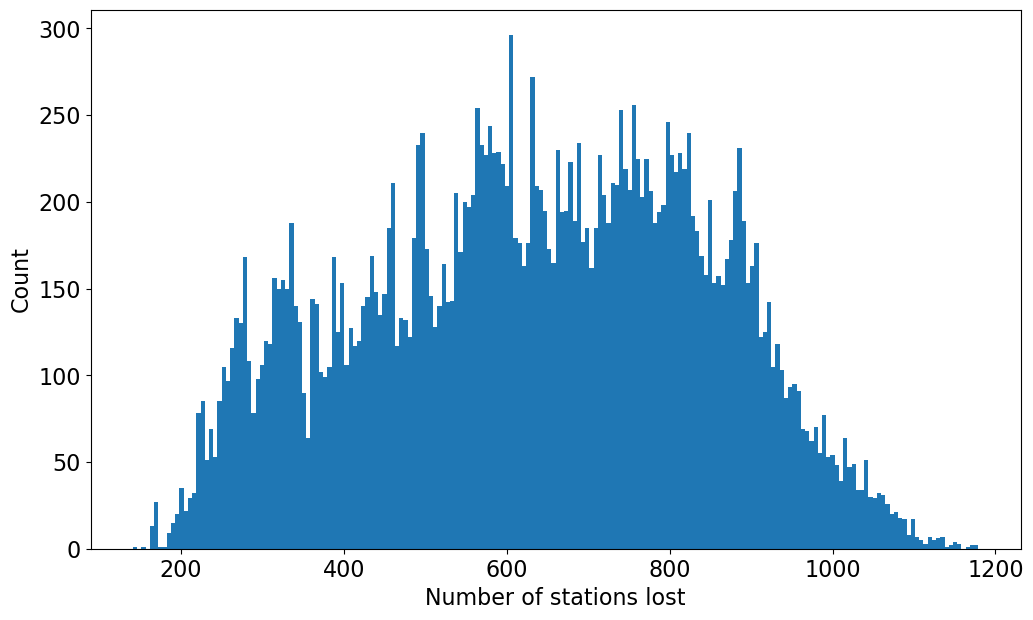

In [60]:
_ =plt.hist(station_count_diff,bins=200)
plt.xlabel("Number of stations lost")
plt.ylabel("Count")

In [9]:
calculate_rmse(scale_1980, scale_all)

62.17340365500134

In [10]:
th1_1980, th2_1980 = get_tercile_val(scale_1980)
th1_all, th2_all = get_tercile_val(scale_all)

Text(0, 0.5, 'all stations')

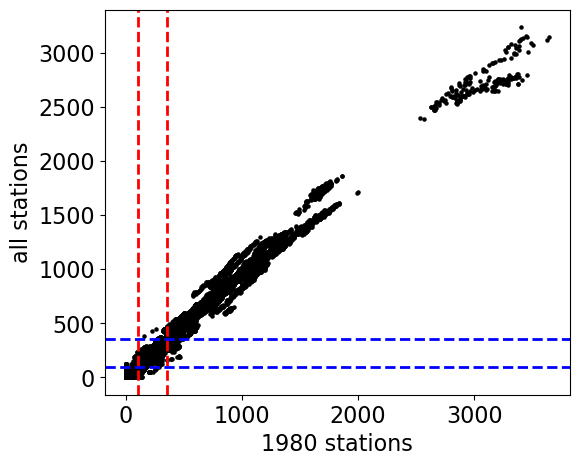

In [11]:
plt.figure(figsize=(6,5))
plt.scatter(scale_1980, scale_all, s=5, color="k")
plt.axvline(x=th1_1980, color='r', linestyle='--')
plt.axvline(x=th2_1980, color='r', linestyle='--')

plt.axhline(y=th1_all, color='b', linestyle='--')
plt.axhline(y=th2_all, color='b', linestyle='--')

plt.xlabel("1980 stations")
plt.ylabel("all stations")

(0.0, 700.0)

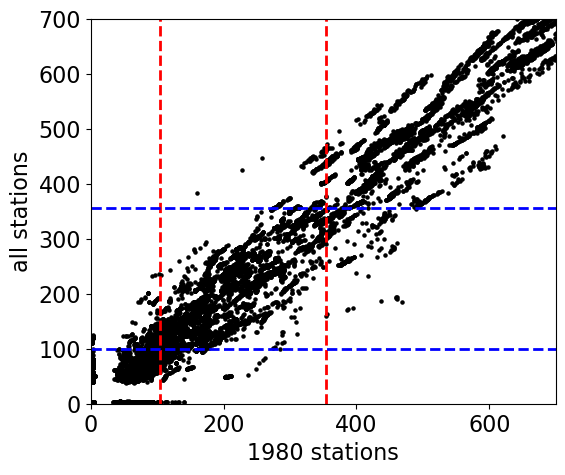

In [12]:
plt.figure(figsize=(6,5))
plt.scatter(scale_1980, scale_all, s=5, color="k")
plt.axvline(x=th1_1980, color='r', linestyle='--')
plt.axvline(x=th2_1980, color='r', linestyle='--')

plt.axhline(y=th1_all, color='b', linestyle='--')
plt.axhline(y=th2_all, color='b', linestyle='--')

plt.xlabel("1980 stations")
plt.ylabel("all stations")
plt.xlim([0,700])
plt.ylim([0,700])

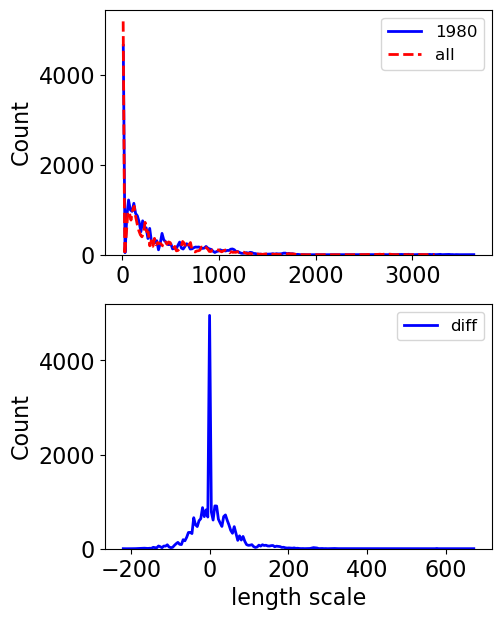

In [30]:
plt.figure(figsize=(5,7))
plt.subplot(211)
count,binx,_ = plt.hist(scale_1980,bins=200,facecolor="w")
bin_centers = 0.5*(binx[1:]+binx[:-1])
plt.plot(bin_centers, count,color="b",label="1980")

count,binx,_ = plt.hist(scale_all,bins=200,facecolor="w")
bin_centers = 0.5*(binx[1:]+binx[:-1])
plt.plot(bin_centers, count,"--",color="r",label="all")
plt.legend()
plt.ylabel("Count")

plt.subplot(212)
count,binx,_ = plt.hist(scale_1980-scale_all,bins=200,facecolor="w")
bin_centers = 0.5*(binx[1:]+binx[:-1])
plt.plot(bin_centers, count,color="b",label="diff")
plt.ylabel("Count")
plt.xlabel("length scale")
plt.legend()

In [17]:

# Compute tercile thresholds
terciles_method1 = np.percentile(scale_all, [33.33, 66.67])
terciles_method2 = np.percentile(scale_1980, [33.33, 66.67])



# Assign tercile categories
tercile1 = assign_tercile(scale_all, terciles_method1)
tercile2 = assign_tercile(scale_1980, terciles_method2)

# Create a DataFrame
df_ter = pd.DataFrame({'Tercile_all': tercile1, 'Tercile_1980': tercile2})

# Compute 3x3 contingency table
contingency_table = df_ter.pivot_table(index='Tercile_all', columns='Tercile_1980', aggfunc='size', fill_value=0)

contingency_table

Tercile_1980,0,1,2
Tercile_all,,,
0,7727,637,0
1,637,7461,267
2,0,267,8097


In [14]:
(637+267)/len(scale_all)

0.03602598334196788

## test Darwin

In [31]:
## test these stations for Brisbane first
## daily center
## consider number of years
center_stations = []
center_radius = 100
center_lat, center_lon =  -12.4239,  130.8925# -27.5436, 152.3375# -31.9275,  117.9764 
for i in range(0,len(df)):
    station  = (df["Latitude"].iloc[i],  df["Longitude"].iloc[i])
    distance = geodesic((center_lat,center_lon), station).kilometers

    if distance <= center_radius and df["Years"].iloc[i]>=20:
            center_stations.append(df["ID"].iloc[i])

df_center_darwin = df[(df["ID"].isin(center_stations)) & (df["End_Year"]>=1960)]  

In [54]:
avail_stn_darwin = []
for stn_id in df_center_darwin["ID"]:
    if os.path.exists(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1980/{stn_id}_pair_scale_moving_list_all_events.csv"):
        avail_stn_darwin.append(stn_id)

scale_1980_darwin = []
scale_all_darwin = []
dates_list_darwin = []
stn_list_darwin = []
station_count_diff_darwin = []
for stn_id in tqdm(avail_stn_darwin,position=0, leave=True):
    df_1980 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1980/{stn_id}_pair_scale_moving_list_all_events.csv",index_col=0)
    df_all = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{stn_id}_pair_scale_moving_list_all_events.csv",index_col=0)
    df_1980_stn = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1980/{stn_id}_station_moving_list_all_events.csv",index_col=0)
    df_all_stn = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{stn_id}_station_moving_list_all_events.csv",index_col=0)
    for dates in df_1980["extreme_dates"]:
        if dates in np.unique(df_all["extreme_dates"]):
            if df_1980["scale"][df_1980["extreme_dates"]==dates].values[0]>1 and df_all["scale"][df_all["extreme_dates"]==dates].values[0]>1:
                stn_count_1980 = len(df_1980_stn[df_1980_stn["Date"]==dates])
                stn_count_all = len(df_all_stn[df_all_stn["Date"]==dates])
                station_count_diff_darwin.append(stn_count_all-stn_count_1980)
                scale_1980_darwin.append(df_1980["scale"][df_1980["extreme_dates"]==dates].values[0])
                scale_all_darwin.append(df_all["scale"][df_all["extreme_dates"]==dates].values[0])
                dates_list_darwin.append(dates)
                stn_list_darwin.append(stn_id)
    
scale_1980_darwin = np.array(scale_1980_darwin)
scale_all_darwin = np.array(scale_all_darwin)

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


Text(0, 0.5, 'Count')

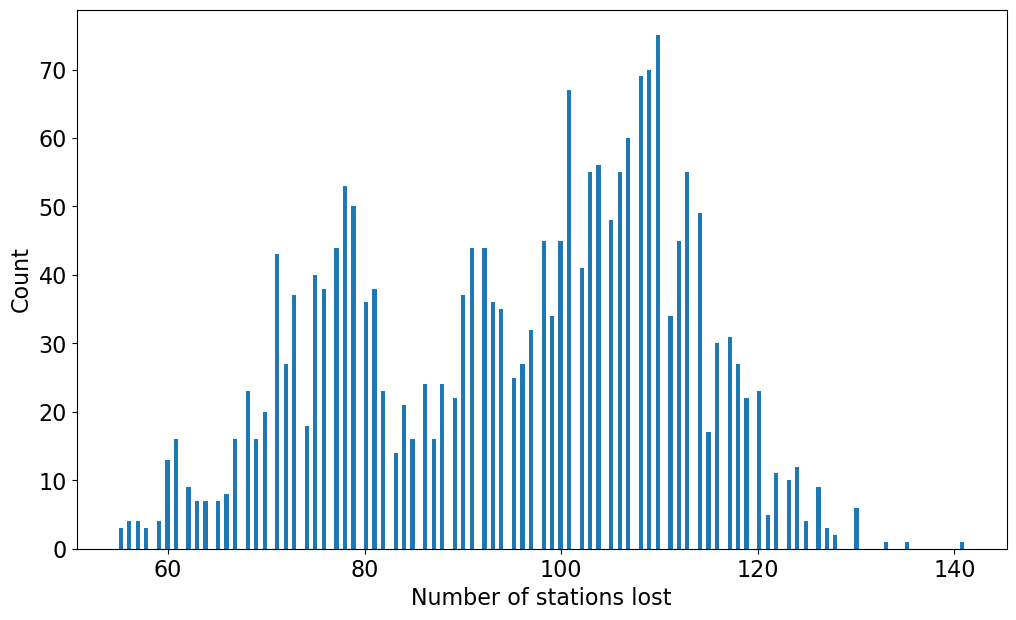

In [57]:
_ =plt.hist(station_count_diff_darwin,bins=200)
plt.xlabel("Number of stations lost")
plt.ylabel("Count")

In [33]:
calculate_rmse(scale_1980_darwin, scale_all_darwin)

89.2856461996131

In [34]:
th1_1980_darwin, th2_1980_darwin = get_tercile_val(scale_1980_darwin)
th1_all_darwin, th2_all_darwin = get_tercile_val(scale_all_darwin)

Text(0, 0.5, 'all stations')

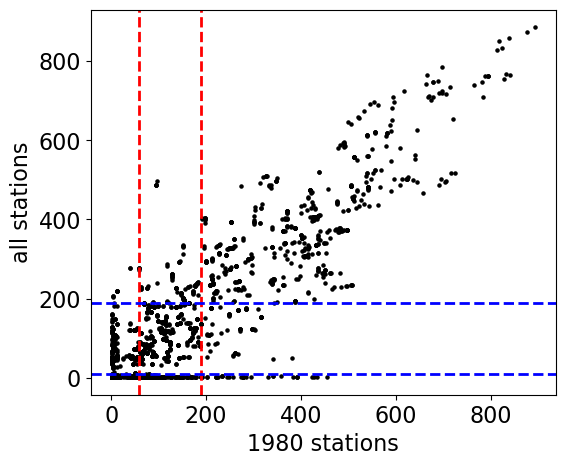

In [35]:
plt.figure(figsize=(6,5))
plt.scatter(scale_1980_darwin, scale_all_darwin,s=5, color="k")
plt.axvline(x=th1_1980_darwin, color='r', linestyle='--')
plt.axvline(x=th2_1980_darwin, color='r', linestyle='--')

plt.axhline(y=th1_all_darwin, color='b', linestyle='--')
plt.axhline(y=th2_all_darwin, color='b', linestyle='--')

plt.xlabel("1980 stations")
plt.ylabel("all stations")

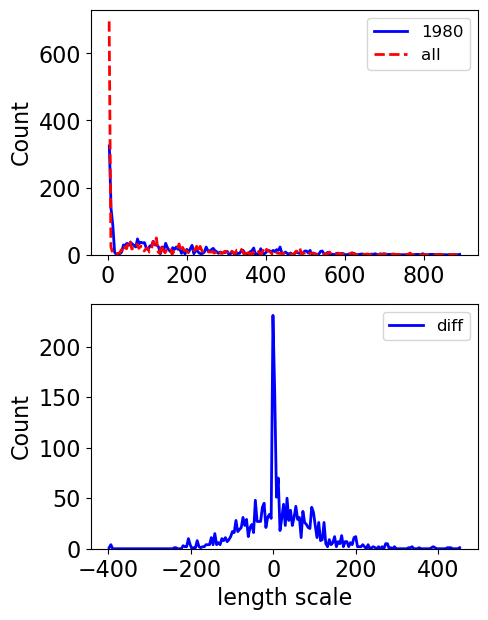

In [36]:
plt.figure(figsize=(5,7))
plt.subplot(211)
count,binx,_ = plt.hist(scale_1980_darwin,bins=200,facecolor="w")
bin_centers = 0.5*(binx[1:]+binx[:-1])
plt.plot(bin_centers, count,color="b",label="1980")

count,binx,_ = plt.hist(scale_all_darwin,bins=200,facecolor="w")
bin_centers = 0.5*(binx[1:]+binx[:-1])
plt.plot(bin_centers, count,"--",color="r",label="all")
plt.legend()
plt.ylabel("Count")

plt.subplot(212)
count,binx,_ = plt.hist(scale_1980_darwin-scale_all_darwin,bins=200,facecolor="w")
bin_centers = 0.5*(binx[1:]+binx[:-1])
plt.plot(bin_centers, count,color="b",label="diff")
plt.ylabel("Count")
plt.xlabel("length scale")
plt.legend()

In [ ]:

# Compute tercile thresholds
terciles_method1 = np.percentile(scale_all_darwin, [33.3, 66.6])
terciles_method2 = np.percentile(scale_1980_darwin, [33.3, 66.6])



# Assign tercile categories
tercile1 = assign_tercile(scale_all_darwin, terciles_method1)
tercile2 = assign_tercile(scale_1980_darwin, terciles_method2)

# Create a DataFrame
df = pd.DataFrame({'Tercile_all': tercile1, 'Tercile_1980': tercile2})

# Compute 3x3 contingency table
contingency_table = df.pivot_table(index='Tercile_all', columns='Tercile_1980', aggfunc='size', fill_value=0)



In [188]:
contingency_table

Tercile_1980,0,1,2
Tercile_all,,,
0,483,194,37
1,217,423,72
2,13,97,606


In [194]:
(194+37+72)/len(scale_all_darwin)

0.14145658263305322

In [195]:
(217+97+13)/len(scale_all_darwin)

0.15266106442577032

In [143]:
72/len(scale_all_darwin)

0.053293856402664694

In [144]:
78/(78+373)

0.1729490022172949